### Robust Design Optimization for shape Optimization of a truss hanger with a hole

This python notebook contains:
 * An ANSYS implementation of a truss hanger with a hole. The shape around the hole is defined by a spline. The hanger is nominally loaded by a normal tension force. Due to imperfections, that force may act at an angle. 
 * A definition of several constraints on the optimized element, e.g. stress, displacement and shape constraints
 * A definition of a penalized objective function, using the above mentioned implementations. 
 * Deterministic shape optimization can be computed, e.g. by scipy's Nelder-Mead method, or any other of the available algorithms
    
Furthermore: 
 * A finite-difference implementation for the computation of numerical gradients
 * Several functions to compute gradients of the objective function and constraints
 * An implementation of a Robust Design objective function, which can be minimized by any inbuilt optimizer

Pre-computed deterministic and robust results are compared in terms of the mean and approximated standard deviations of volume, stress and displacement

The model is defined as follows:

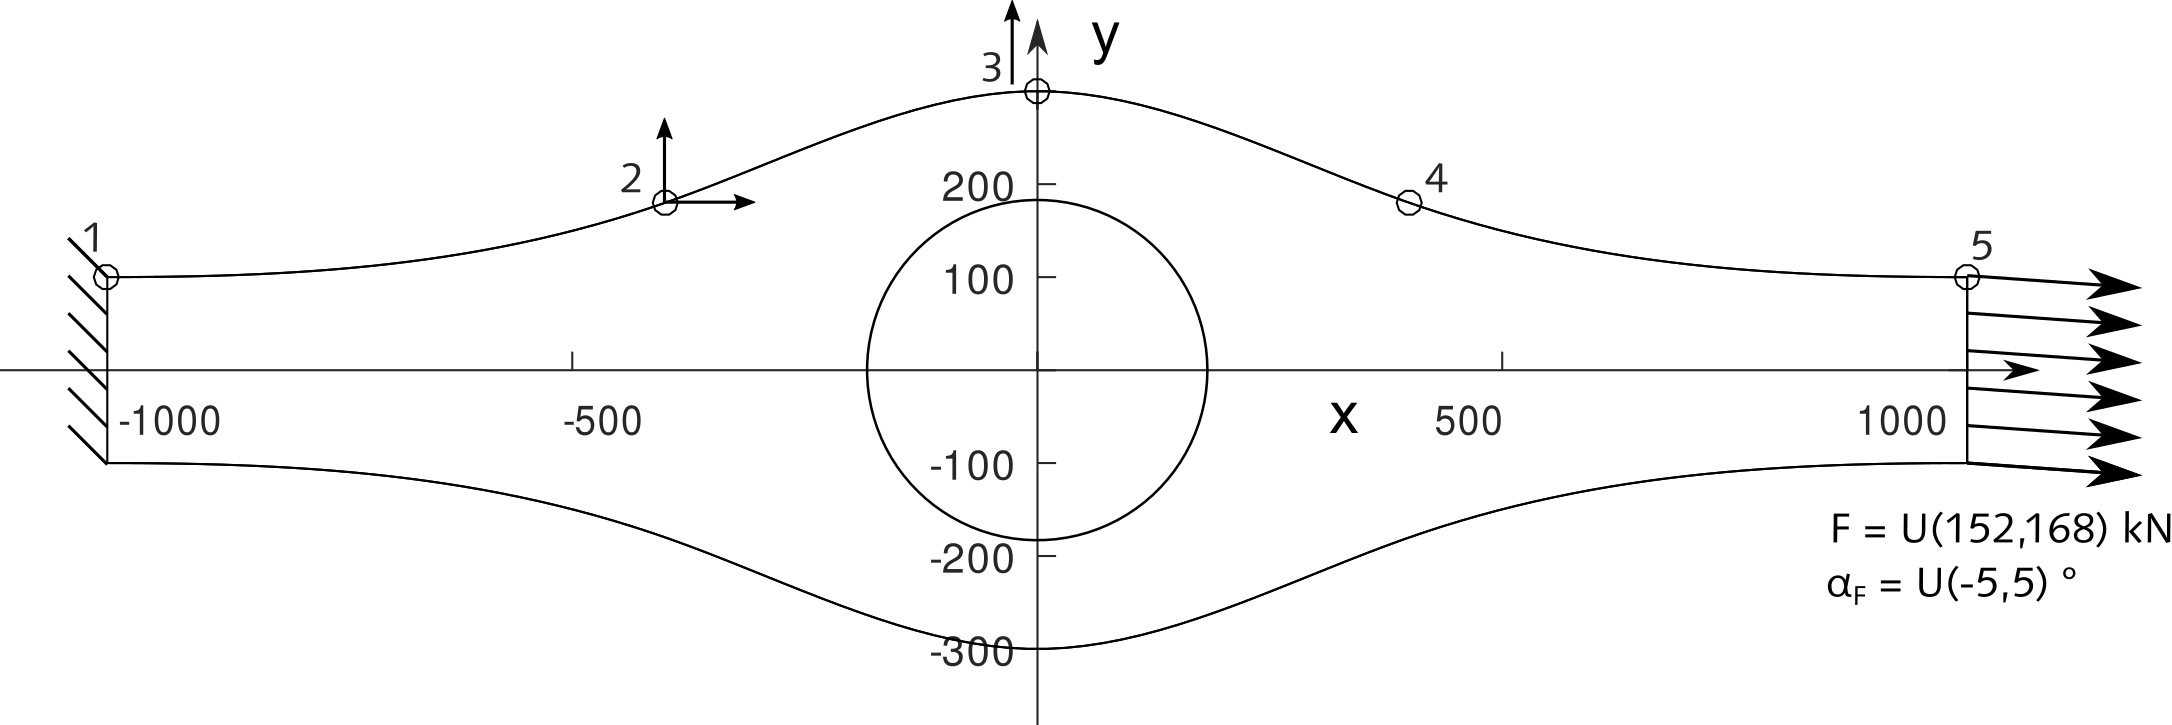

It is symmetric about the x and y axis and the design parameters ar the coordinates of knots 2 and 3 as indicated by the arrows. Aditionally, there is uncertainty about the force amplitude and angle of attack, as shown in the drawing.

In [1]:
import os
import sys
import glob
import shutil

import numpy as np
import scipy.optimize
import scipy.interpolate
import matplotlib.pyplot as plt

from IPython.display import clear_output

import pyansys

cwd='/dev/shm/womo1998/'
if not os.path.exists(cwd):
    os.makedirs(cwd)

rd='/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization'

global mapdl
mapdl = pyansys.launch_mapdl(
            exec_file='/vegas/apps/ansys/v201/ansys/bin/ansys201',
            run_location=cwd, override=True, loglevel='ERROR',
            nproc=1, log_apdl='w',
            log_broadcast=False, jobname='file',
            mode='console', additional_switches='-smp')

In [2]:
# inputfile = '/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/code/ansysInput.in'
# pyscript = '/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/code/ansysInput.py'
# pyansys.convert_script(inputfile, pyscript)

In [3]:
# use this cell to restart ANSYS in case of crashes or unexplained errors
global mapdl
mapdl.exit()
files = glob.glob(cwd + '*')
for f in files:
    os.remove(f)

mapdl = pyansys.launch_mapdl(
            exec_file='/vegas/apps/ansys/v201/ansys/bin/ansys201',
            run_location=cwd, override=True, loglevel='ERROR',
            nproc=1, log_apdl='w',
            log_broadcast=False, jobname='file',
            mode='console', additional_switches='-smp')

#### Problem definition (objective, constraints and penalty function)

This uses pyansys version 0.44.15 . Due to rapid development of pyansys, it might not be fully compatible with other versions. The main advantage over writing an input file, starting ansys externally and reading in results, is the substantially reduced overhead, by keeping ANSYS started between consecutive runs. 

In [8]:
global mapdl
global iter
iter = 0
def truss_hole(x, y, plot=True):
    '''
    x are the design variables, e.g. x_2, y_2, y_3
    y are the problem parameters, e.g. pressure [N/mm²], load_angle [degrees]
    '''
    
    if plot: clear_output(wait=True)
    global iter
    iter += 1

    global radius
    radius = 180 # mm
    
    if x[0]>=1000:
        print("Horizontal component of knot 2 must not be less than -1000 \n")
        return 3e12, 0, 0, np.min(x[1:]), 0
    
    knots_x=[-1000,-x[0],0,x[0],1000]
    knots_y=[100,x[1],x[2],x[1],100]
    cs = scipy.interpolate.CubicSpline(knots_x, knots_y, bc_type=((1, 0.0), (1, 0.0)))
    xx_spline = np.linspace(min(knots_x),max(knots_x))
    yy_spline = cs(xx_spline)
    
    shape_deriv = np.diff(yy_spline[:yy_spline.size // 2]) / np.diff(xx_spline[:xx_spline.size // 2])
    
    #Hard constraints
    if np.sqrt(x[0]**2+x[1]**2)<=radius: # circle radius must be less than x component of the spline node
        print("Circle radius must be less than x component of the spline node \n")
        #return volume, stress, displacement, np.min(yy_spline), np.min(shape_deriv)
        return 3e12, 0, 0, np.min(yy_spline), np.min(shape_deriv)
    elif x[2]<=radius: # circle radius must be less than the spline top height
        print("Circle radius must be less than the spline top height \n")
        return 3e12, 0, 0, np.min(yy_spline), np.min(shape_deriv)
    elif np.any(yy_spline<=0):
        print("Top and bottom splines must not intersect")
        return 3e12, 0, 0, np.min(yy_spline), np.min(shape_deriv)
    
    
    mapdl.finish()
    mapdl.clear()
    mapdl.nolist()
    mapdl.run("/PREP7				")  # Preprocessor
    mapdl.k(1, -1000, 100)  #create key points
    mapdl.k(2, -x[0], x[1])
    mapdl.k(3, 0, x[2])
    mapdl.k(4, x[0], x[1])
    mapdl.k(5, 1000, 100)
    mapdl.k(6, 1000, -100)
    mapdl.k(7, x[0], -x[1])
    mapdl.k(8, 0, -x[2])
    mapdl.k(9, -x[0], -x[1])
    mapdl.k(10, -1000, -100)
    
    mapdl.bsplin(1, 2, 3, 4, 5, "", -1, "", "", 1, "", "")  #create spline (top)
    mapdl.bsplin(6, 7, 8, 9, 10, "", 1, "", "", -1, "", "")  #create spline (bottom)
    
    
    mapdl.l(5, 6)
    mapdl.l(10, 1)
    mapdl.al(1, 2, 3, 4)  #fill line polygon
    
    mapdl.cyl4(0, 0, radius)  #circle,center coords, radius
    mapdl.asba(1, 2)  #substract area 2 from area 1
    mapdl.et(1, "PLANE182")  #element Type = plane 42
    mapdl.keyopt(1, 1, 3)  #This is the changed option to give the plate a thickness
    mapdl.keyopt(1, 3, 3)  #This is the changed option to give the plate a thickness
    mapdl.r(1, 40)  #Real Constant, Material 1, Plate Thickness
    mapdl.mp("EX", 1, 210000)  #Material Properties, Young's Modulus, Material 1, 210000 MPa
    mapdl.mp("PRXY", 1, 0.3)  #Material Properties, Major Poisson's Ratio, Material 1, 0.3
    mapdl.aesize("ALL", 25)  #Element sizes, all of the lines, 10 mm
    mapdl.amesh("ALL")  #Mesh the lines
    mapdl.lsel("S", "LINE", "", 1)  #Select first spline
    
    mapdl.nsll("S", 1)  #Select nodes attached to spline
    mapdl.ksel("S","KP",1)

    
    '''
    Unfortunately ANSYS generates a slightly different spline than both
    python and MATLAB. There is no obvious reason or setting for why 
    that is. So in order to check the shape constraints, we need to 
    extract the actual nodal coordinates used in the model
    '''
    mapdl.gopr()
    mapdl.starvget("NODES", "NODE","","NLIST")
    nlist = mapdl.parameters["NODES"]
    mapdl.dim("XN","ARRAY", len(nlist), 1, "")
    mapdl.dim("YN","ARRAY", len(nlist), 1, "")
    for ind,node in enumerate(nlist.astype(int)):
        mapdl.starvget(f"XN({ind+1})", "NODE", node, "LOC", "X", "", "", "2") 
        mapdl.starvget(f"YN({ind+1})", "NODE", node, "LOC", "Y", "", "", "2") 
    
    xx_spline = mapdl.parameters["XN"]
    yy_spline = mapdl.parameters["YN"]
    argsort = np.argsort(xx_spline)
    xx_spline = xx_spline[argsort]
    yy_spline = yy_spline[argsort]
    mapdl.nopr()
    
    
    mapdl.nsel("ALL")
    mapdl.lsel("ALL")
    mapdl.ksel("ALL")
    mapdl.finish()  #Exit preprocessor
    mapdl.run("/SOLU")  # Solution
    mapdl.antype(0)  #The type of analysis (static)
    mapdl.dl(4, "", "ALL", 0)  #Apply a Displacement to Line 4 to all DOF
    
    mapdl.lsel("S", "LINE", "", 3)
    mapdl.nsll("S", 3)
    
    # define angle of surface load
    mapdl.run(f"SFCONTROL,2,,{-np.cos(y[1]/180*np.pi)},{-np.sin(y[1]/180*np.pi)},0,")
    mapdl.sf("ALL", "PRES", -y[0])
    mapdl.allsel()
    mapdl.solve()  #Solve the problem
    mapdl.finish()
    mapdl.run("/POST1")  # Enter the post-processor
    mapdl.run("/DSCALE,ALL,1.0")  # Set deformation scale to 1.0
    mapdl.run("/SHOW,PNG")  # save to png file
    mapdl.plnsol("S", "EQV", 2, 1.0)  #plot equivalent stress
    # Find maximum stress
    mapdl.run("*GET,STRESSEQ,PLNSOL,0,MAX 	")  # Maximum value of item in last contour display
    mapdl.plnsol("U", "SUM")
    # Find maximum displacement
    mapdl.run("*GET,MAXDISP,PLNSOL,0,MAX 	")  # Maximum value of item in last contour display
    mapdl.run("/SHOW,TERM")
    mapdl.plnsol("S", "EQV", 2, 1.0)  #plot equivalent stress
    # Compute volume, this only works if ANSYS was started with the -smp switch
    mapdl.etable("ELMVOL", "VOLU")
    mapdl.ssum()
    mapdl.run("*GET,TOTVOL,SSUM,,ITEM,ELMVOL")
    mapdl.finish()
    volume = mapdl.parameters["TOTVOL"]
    stress = mapdl.parameters["STRESSEQ"]
    displacement = mapdl.parameters["MAXDISP"]
    
    if plot:
        fig = plt.figure(1, clear=True, figsize=(16,9.6)) # actual max width of output_subarea = 986 px @ 96 DPI
        ax = plt.subplot()
        img = plt.imread(os.path.join(cwd,"file000.png"))
        ax.imshow(img)
        ax.axis('off')  # clear x-axis and y-axis
        plt.show(block=False)
        os.rename(os.path.join(cwd,"file000.png"), os.path.join(cwd,f"stresses_{iter:03d}.png"))
        
    for f in glob.glob(os.path.join(cwd,"file*.png")):
        os.remove(f)
    
    shape_deriv = np.diff(yy_spline[:yy_spline.size // 2]) / np.diff(xx_spline[:xx_spline.size // 2])
    
    return volume, stress, displacement, np.min(yy_spline), np.min(shape_deriv)

    
def constr(a, b, c=None, d=None, e=None, **kwargs):
    '''
    Evaluate constraints
    '''
    # allow two arguments to enable gradient computation
    # or four arguments to avoid computing the same objective twice
    if c is None or d is None:
        x, y = a, b
        volume, stress, displacement, min_y, min_slope = truss_hole(x,y, **kwargs)
    else:
        volume, stress, displacement, min_y, min_slope  = a, b, c, d, e
    
    maxStress = 240 #N/mm^2
    maxDisp = 2 # mm
    
    stress_c = max(0, (stress - maxStress) / maxStress)
    disp_c = max(0, (np.abs(displacement) - maxDisp) / maxDisp)
    shape_c = max(0, 100 - min_y)
    slope_c = max(0, - min_slope)
    
    return stress_c, disp_c, shape_c, slope_c

def obj_constr(a, b, c=None, d=None, e=None, **kwargs):
    '''
    Evaluate constraints and objective
    (used to avoid doubling model calls for computing gradients)
    '''
    
    # allow two arguments to enable gradient computation
    # or four arguments to avoid computing the same objective twice
    if c is None or d is None:
        x, y = a, b
        volume, stress, displacement, min_y, min_slope = truss_hole(x,y, **kwargs)
    else:
        volume, stress, displacement, min_y, min_slope  = a, b, c, d, e
    
    maxStress = 240 #N/mm^2
    maxDisp = 2 # mm

    stress_c = max(0, (stress - maxStress) / maxStress)
    disp_c = max(0, (np.abs(displacement) - maxDisp) / maxDisp)
    shape_c = max(0, 100 - min_y)
    slope_c = max(0, - min_slope)
    
    return volume, stress, displacement, min_y, min_slope, stress_c, disp_c, shape_c, slope_c

def objective_penalized(x,y=[-20, 0], **kwargs):
    '''
    Penalized objective for deterministic shape optimization
    '''
    volume, stress, displacement, min_y, min_slope  = truss_hole(x, y,**kwargs)
    
    constraints = np.array(constr(volume, stress, displacement, min_y, min_slope ), dtype=float)
    
    objective = volume
    
    messages=["maxStress exceeded", 
              "maxDisplacement exceeded", 
              "Element must not be thinner than 200 mm", 
              "Slope must be positive"]
    
    # the stress and displacement constraints are most important, where the latter is almost never reached
    # the shape constraint becomes quite dominant, so we use a small factor
    # the slope constraint is also less relevant
    r = [2.0, 2.0, 0.1, 0.1] 
    constraints *= r
    for constraint, msg in zip(constraints, messages):
        if constraint > 0:
            print(f"{msg}. penalty: {((1 + np.abs(constraint))**2-1)*100:.3f} %")
            objective *= (1 + np.abs(constraint))**2
    
    return objective

#### Deterministic optimization with normal tensile force  (takes 315 function evaluations ~ 6 min.)

Pre-computed result:
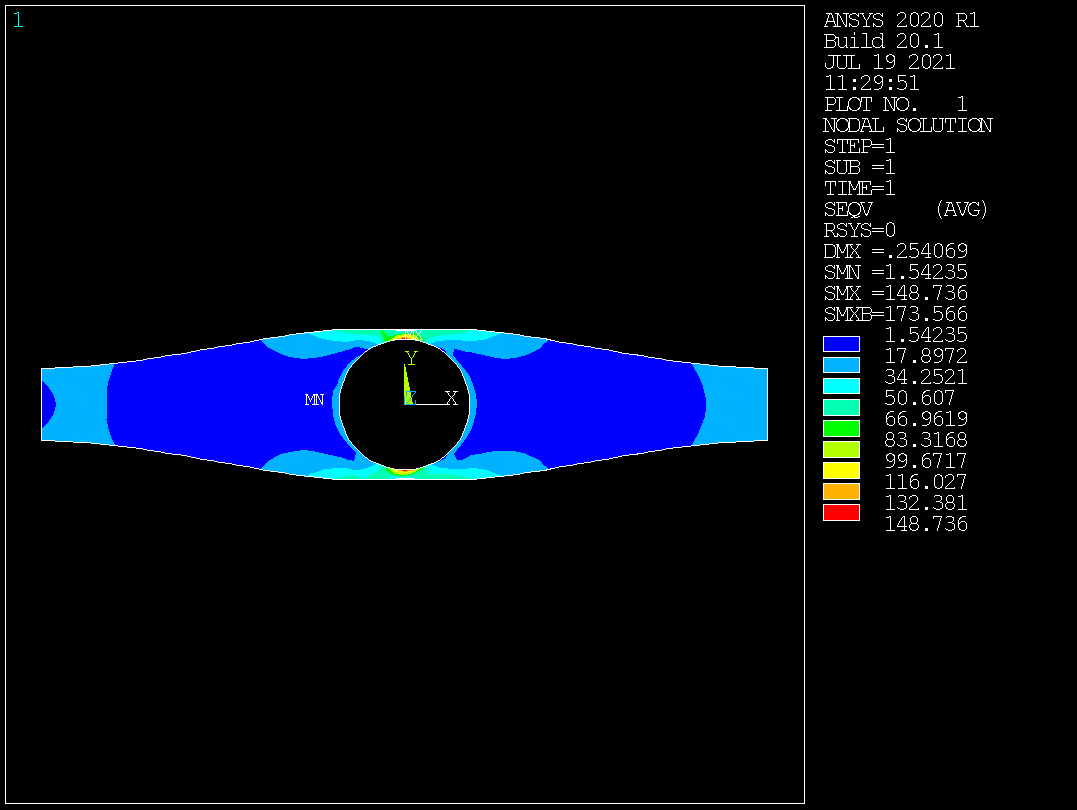

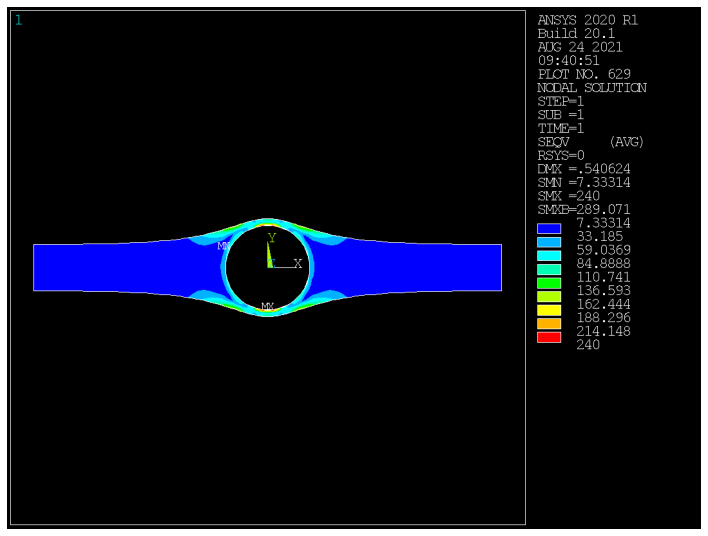

Element must not be thinner than 200 mm. penalty: 0.254 %
Slope must be positive. penalty: 0.006 %
Optimization terminated successfully.
         Current function value: 16398630.260919
         Iterations: 151
         Function evaluations: 315
Found optimum at [274.31948708 139.74287517 208.75200647] after 315 model calls.


In [5]:
#truss_hole([250,215,300],[-20,0])
global iter
iter = 0
minimum = scipy.optimize.fmin(func=objective_penalized, x0=[251,200,205],args=([-20, 0],))
print(f'Found optimum at {minimum} after {iter} model calls.')
for f in glob.glob(os.path.join(cwd,"stresses*.png")):
    fname = os.path.split(f)[1]
    shutil.move(f, f'/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/deterministic_straight/{fname}')

#### Deterministic optimization with tensile force at an angle of 5°   (takes 489 function evaluations ~x:xx min.)
Pre-computed result:
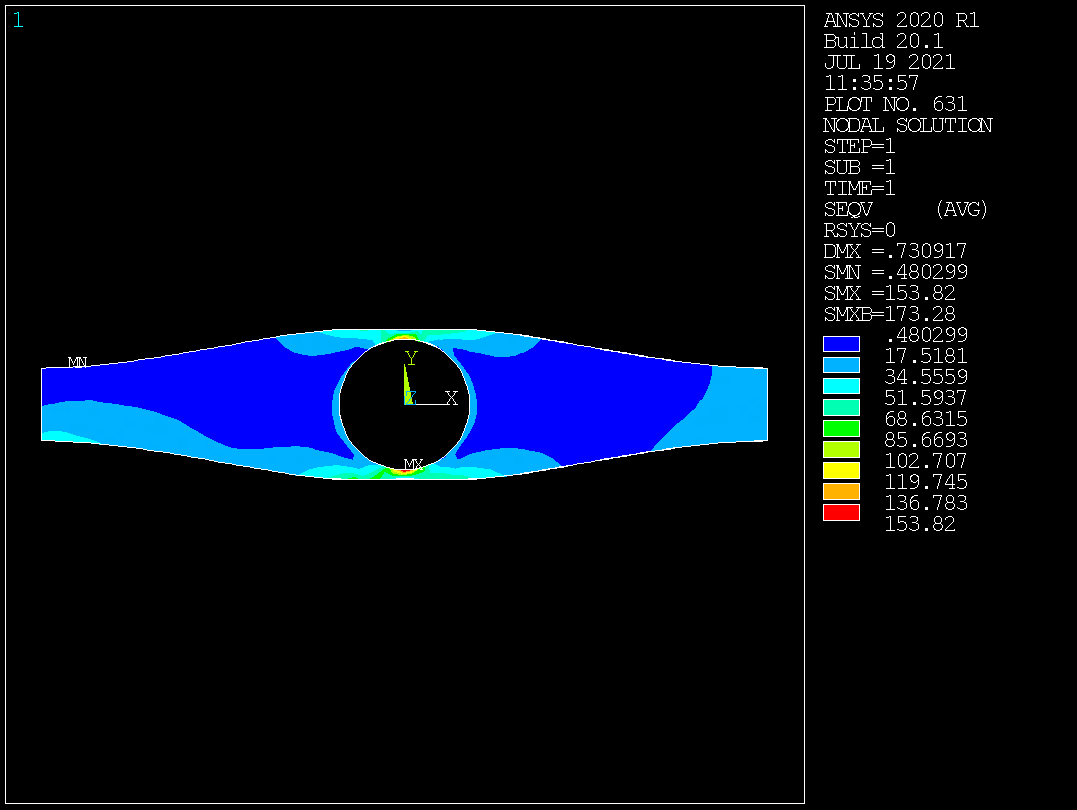

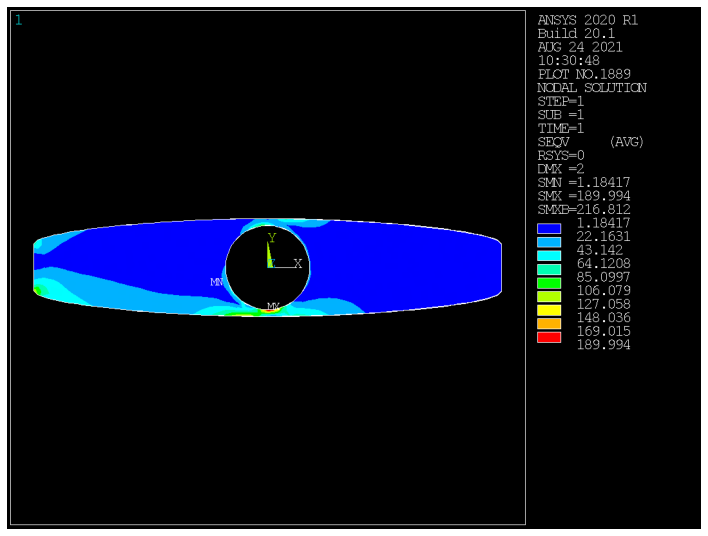

Optimization terminated successfully.
         Current function value: 25018334.400000
         Iterations: 213
         Function evaluations: 489
Found optimum at [991.37026262 110.05429991 208.89223417] after 489 model calls.


In [9]:
global iter
iter = 0
minimum = scipy.optimize.fmin(func=objective_penalized, x0=[251,200,205],args=([-20, 5],))
print(f'Found optimum at {minimum} after {iter} model calls.')
for f in glob.glob(os.path.join(cwd,"stresses*.png")):
    fname = os.path.split(f)[1]
    shutil.move(f, f'/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/deterministic_angled/{fname}')

### Definitions for Robust Design Optimization

 * Finite difference gradient computation
 * Penalized robust objective
 * Variance computation for objective and constraints

In [10]:
def gradient(func, x0, y0, s, n_out = None, dims=None, **kwargs):
    '''
    Computes the gradient by a finite difference scheme
    
    x0 and y0 are concatenated for form an m_dimensional point,
    where the gradient is evaluated
    with stepsize s (may be different for each dimension)
    for n_out output_parameters
    
    to reduce computational costs, the gradient may be computed
    only in some dimensions included in the list dims, the 
    entries in the other dimensions will then remain zero
    
    final shape is (n_out, m_dimensions)
    
    '''
    dim_x = len(x0)
    dim_y = len(y0)
    all_dim = dim_x + dim_y
    
    if dims is None:
        dims = list(range(all_dim))
    
    if n_out is None:
        n_out = len(func(xp, yp, **kwargs))
    
    assert max(dims)<=all_dim
    
    if isinstance(s, (float, int)):
        s = np.ones((all_dim,)) * s
    assert len(s) == all_dim
    
    g = np.zeros((all_dim, n_out))
    for d  in dims:
        ds = np.zeros((all_dim,))
        ds[d] = s[d]
        xp = x0 + ds[:dim_x]
        xm = x0 - ds[:dim_x]
        yp = y0 + ds[dim_x:]
        ym = y0 - ds[dim_x:]
        #print(yp, ym)
        fp = np.array(func(xp, yp, **kwargs))
        fm = np.array(func(xm, ym, **kwargs))
        df_dx = (fp - fm) / (2 * s[d])
        g[d,:] = df_dx
        #print(d, df_dx)
        #print(g)
    #g /= np.linalg.norm(g)
    return g

def objective_robust_penalized(x, y, s_x, s_y, r_x, r_y):
    '''
    Penalized robust objective
    
    evaluates model and constraints and makes them robust by adding variances and boundaries
    
    applies (robust) constraints by penalizing the (robust) objective
    
    Parameters:
        x: design variables (knot coordinates)
        y: problem parameters (load amplitude and angle)
        s_x: standard deviations of design variables
        s_y: standard deviations of problem parameters
        r_x: boundary intervals of design variables
        r_y: boundary intervals of problem parameters
    '''
    global iter
    
    w1=0.5
    w2=0.5
    k=0.5
    
    mu_f, stress, displacement, shape, slope = truss_hole(x,y) # Eq. 19.52
    mu_g = constr( mu_f, stress, displacement, shape, slope) # assuming Eq. 19.52 applies here as well
    
    V, B_g = variance_obj_constr(x,y, s_x, s_y, r_x, r_y)
    s_f = np.sqrt(V[0]) 
    
    objective = w1 * mu_f + w2 * s_f # Eq. 19.49, uses std.dev.
    constraints = mu_g + k * B_g[-4:] # Eq 19.51 
    
    messages=["maxStress exceeded", 
              "maxDisplacement exceeded", 
              "Element must not be thinner than 200 mm", 
              "Slope must be positive"]
    
    # the stress and displacement constraints are most important, where the latter is almost never reached
    # the shape constraint becomes quite dominant, so we use a small factor
    # the slope constraint is also less relevant
    r = [2, 2, 0.1, 0.1] 
    constraints *= r
    outs = [stress, displacement, shape, slope]
    # evaluate and penalize constraints
    with open('/vegas/scratch/womo1998/logfile.log', 'at') as f:
        print(iter, file=f)
        for i,(constraint, msg) in enumerate(zip(constraints, messages)):
            if constraint > 0:
                print(f"{msg}. ({outs[i]},  unc. bound {(k*B_g)[i]}, constr. {mu_g[i]}) penalty: {((1 + np.abs(constraint))**2-1)*100:.3f} %", file=f)
                objective *= (1 + np.abs(constraint))**2
    
    return objective

def variance_obj_constr(x, y, s_x, s_y, r_x, r_y):
    '''
    compute variances of the objective and the constraints
    by a finitite difference gradient approximation and 
    assuming a first-order taylor expansion of the objective / constraint
    '''    
    s_xy = np.hstack([s_x, s_y])
    r_xy = np.hstack([r_x, r_y])
    step = r_xy / 2
    step[step==0] = 1
    
    grad_dims = np.where(s_xy!=0)[0]
    # if only the problem parameters are uncertain, shape and volume gradients are always zero
    grad = gradient(obj_constr, x, y, step, 9, dims=grad_dims, plot=False)
    
    V = np.sum((grad**2 * s_xy[:,np.newaxis]**2), axis=0)
    
    
    B_g = np.sum((np.abs(grad) * np.abs(r_xy[:,np.newaxis])), axis=0) # worst case bounds of G
    
    return V, B_g

#### Robust Design Optimization with a tensile force uncertain in amplitude and angle of attack (takes 412 function evaluations  ~ 30 mins.)
each function evaluation calls the model (ANSYS) 5 times (once for mu_f and mu_g and 4 times for gradients of f and g) that makes 2060 model calls
Pre-computed result:
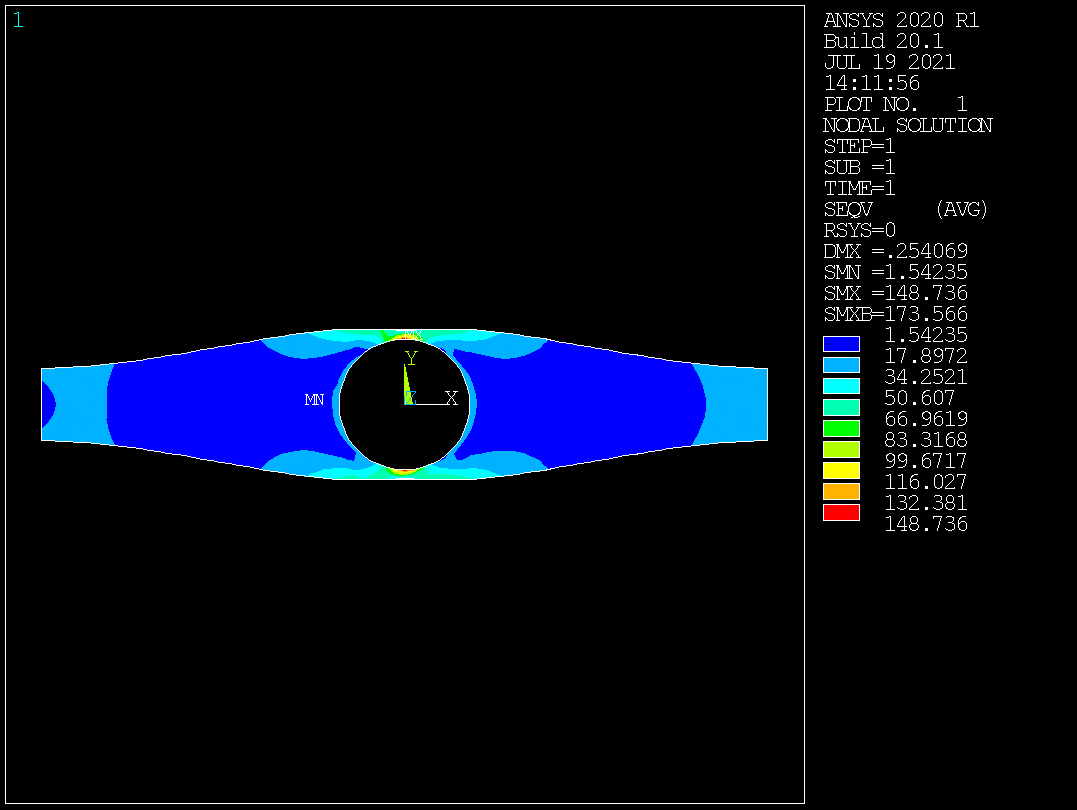

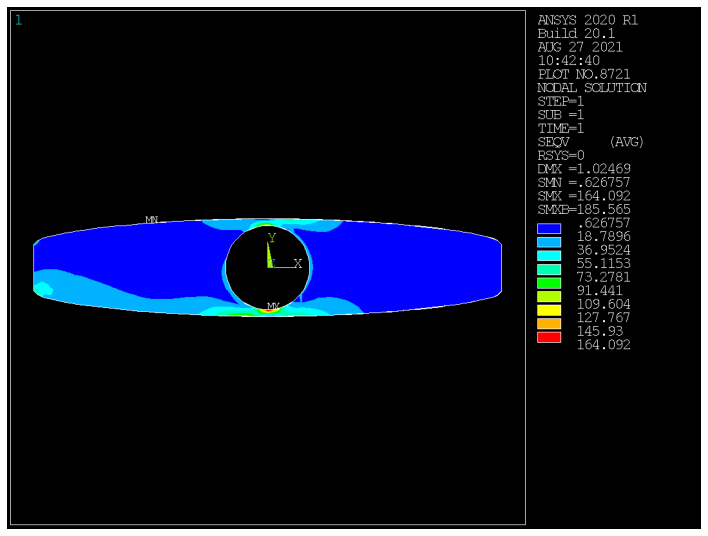

Optimization terminated successfully.
         Current function value: 12499532.900000
         Iterations: 175
         Function evaluations: 349
Found optimum at [992.18923556 109.65877705 208.78208585] after 1745 model calls.


In [12]:
# design variables: x_2, y_2, y_3 deterministic -> stdev = 0
# parameters: load U(-19,-21) N/mm², angle U(0, 5) ° -> mu = (a-b) / 2, stdev = np.sqrt( (a-b)/12 )
global iter
iter = 0
#x0 = [253.61822862, 129.81732176, 175.56403217]
x0 = [251,200,205]
minimum = scipy.optimize.fmin(func=objective_robust_penalized, 
                    x0=x0, # design variables x
                    args=([-20, 2.5], # parameters y
                          [0, 0, 0], # uncertainties of design variables
                          [np.sqrt(2/12), np.sqrt(5/12)],# uncertainties of parameters
                          [0, 0, 0], # uncertain range of design variables
                          [2, 5]))  # uncertain range of parameters
print(f'Found optimum at {minimum} after {iter} model calls.')
for f in glob.glob(os.path.join(cwd,"stresses*.png")):
    fname = os.path.split(f)[1]
    shutil.move(f, f'/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/robust/{fname}')

#### Computing the robustness of the two deterministic and the robust optima

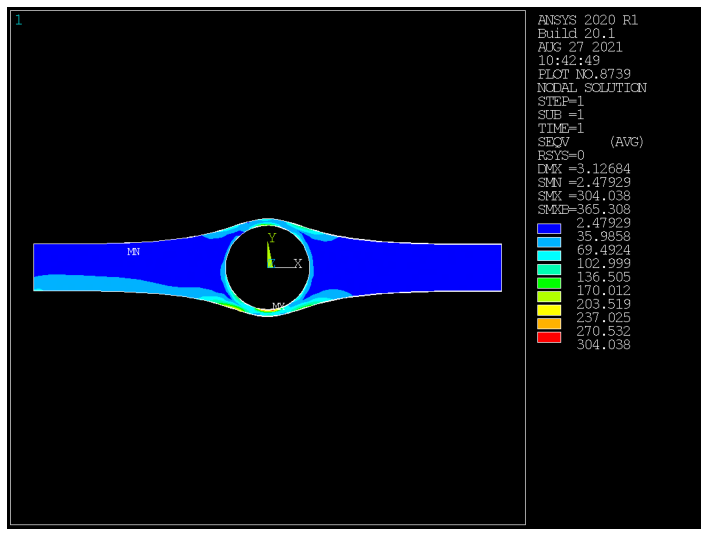

min. volume 	16356069.4 	(std 0.0),
max. stress 	304.038 ±12.577 	(std 17.626),
max. displ. 	3.127±2.431 	(std 0.726) 


In [13]:
# deterministic optimum with straight force
xopt=[274.31948708, 139.74287517, 208.75200647]
# Variance of: volume, stress, displacement, width, slope with respect to uncertainties in load amplitude and angle
V, B_g = np.sqrt(variance_obj_constr(xopt,[-20, 2.5], 
                                  [0, 0, 0], [np.sqrt(2/12), np.sqrt(5/12)],
                                  [0, 0, 0], [2,5]))

vol, stress, disp,_ , _ = truss_hole(xopt, [-20, 2.5])

print(f'min. volume \t{vol:.1f} \t(std {V[0]}),\nmax. stress \t{stress:.3f} ±{B_g[1]:.3f} \t(std {V[1]:.3f}),\nmax. displ. \t{disp:.3f}±{B_g[2]:.3f} \t(std {V[2]:.3f}) ')


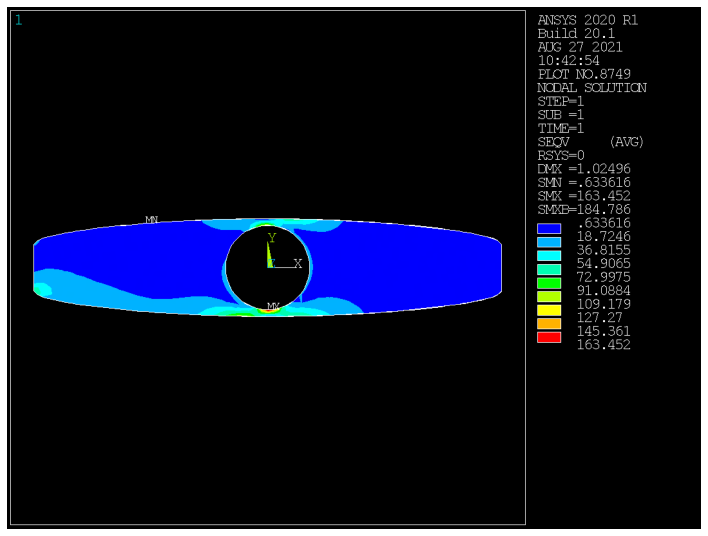

min. volume 	25018334.4 	(std 0.0),
max. stress 	163.452 ±8.360 	(std 7.676),
max. displ. 	1.025±1.369 	(std 0.230) 


In [14]:
# deterministic optimum with force at an angle
xopt = [991.37026262, 110.05429991, 208.89223417]
# Variance of: volume, stress, displacement, width, slope with respect to uncertainties in load amplitude and angle
V, B_g = np.sqrt(variance_obj_constr(xopt,[-20, 2.5], 
                                  [0, 0, 0], [np.sqrt(2/12), np.sqrt(5/12)],
                                  [0, 0, 0], [2,5]))

vol, stress, disp,_ , _ = truss_hole(xopt, [-20, 2.5])

print(f'min. volume \t{vol:.1f} \t(std {V[0]}),\nmax. stress \t{stress:.3f} ±{B_g[1]:.3f} \t(std {V[1]:.3f}),\nmax. displ. \t{disp:.3f}±{B_g[2]:.3f} \t(std {V[2]:.3f}) ')


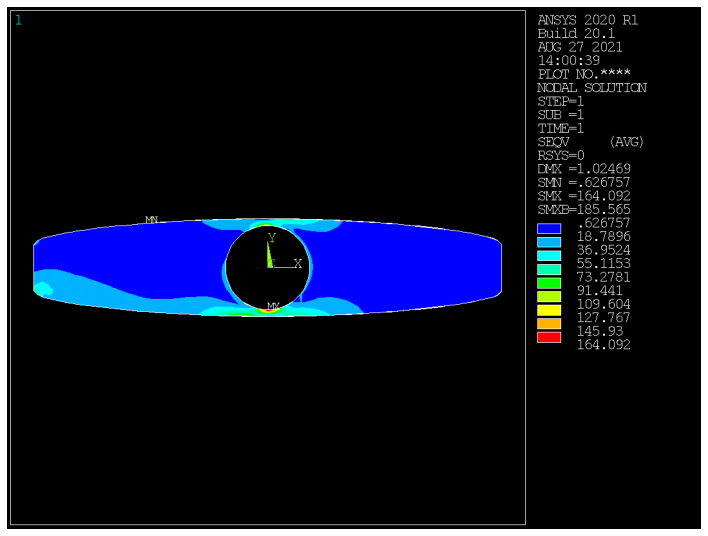

min. volume 	24999065.8 	(std 0.0),
max. stress 	164.092 ±8.378 	(std 7.708),
max. displ. 	1.025±1.369 	(std 0.230) 


In [24]:
# robust optimum
xopt = [992.18923556, 109.65877705, 208.78208585]
# Variance of: volume, stress, displacement, width, slope with respect to uncertainties in load amplitude and angle
V, B_g = np.sqrt(variance_obj_constr(xopt,[-20, 2.5], 
                                  [0, 0, 0], [np.sqrt(2/12), np.sqrt(5/12)],
                                  [0, 0, 0], [2,5]))

vol, stress, disp,_ , _ = truss_hole(xopt, [-20, 2.5])

print(f'min. volume \t{vol:.1f} \t(std {V[0]}),\nmax. stress \t{stress:.3f} ±{B_g[1]:.3f} \t(std {V[1]:.3f}),\nmax. displ. \t{disp:.3f}±{B_g[2]:.3f} \t(std {V[2]:.3f}) ')


#### Verification by Monte Carlo Simulation

Turns out, the structure was still not robust enough. Stresses exceeded 240 MPa in most samples, also displacements did. That might be related to a strong nonlinear dependency of the gradient on the load angle, where the step size might not be big enough, or some other effect related to scaling.

The RDO was repeated with partly increased stepsize for the gradient approximation, which resulted in a much thicker design. In a MCS it complies to the stress constraints, but not the displacement constraints. Could this be due to interaction effects between load amplitude and angle, which are not properly caught by the gradient approximation? For each (amplitude, angle) the gradient is computed at the nominal values of the other.

In [21]:
global iter
iter = 0

N = 500
xopt = [992.18923556, 109.65877705, 208.78208585]
y = np.empty((N, 2))
y[:,0] = np.random.uniform(-19, -21, N)
y[:,1] = np.random.uniform(0, 5, N)

f = np.zeros((N, 5)) # volume, stress, displacement, shape, slope

for n in range(N):
    f[n, :] = truss_hole(xopt, y[n, :], plot=False)
np.savez('/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/MCS/data.npz',**{'y':y,'f':f})

for f in glob.glob(os.path.join(cwd,"stresses*.png")):
    fname = os.path.split(f)[1]
    shutil.move(f, f'/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/MCS/{fname}')    


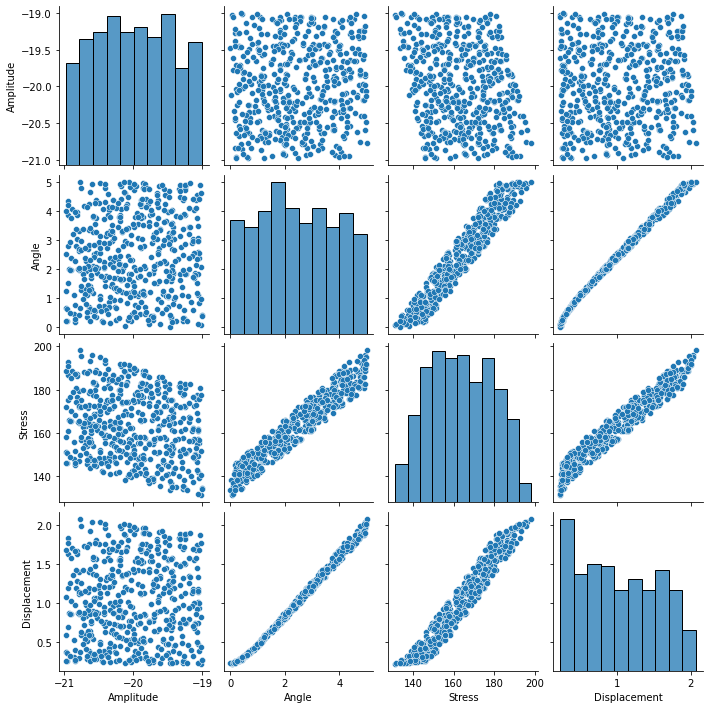

In [22]:
import seaborn as sns
import pandas as pd
in_dict = np.load('/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/MCS/data.npz')
y, f = in_dict['y'], in_dict['f']
df = pd.DataFrame(np.hstack([y,f[:,1:3]]), columns=['Amplitude', 'Angle', 'Stress', 'Displacement'])
sns.pairplot(df)

In [18]:
global iter
iter = 0

N = 500
xopt = [274.31948708, 139.74287517, 208.75200647]
y = np.empty((N, 2))
y[:,0] = np.random.uniform(-19, -21, N)
y[:,1] = np.random.uniform(0, 5, N)

f = np.zeros((N, 5)) # volume, stress, displacement, shape, slope

for n in range(N):
    f[n, :] = truss_hole(xopt, y[n, :], plot=False)
np.savez('/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/MCS/data_determ.npz',**{'y':y,'f':f})

for f in glob.glob(os.path.join(cwd,"stresses*.png")):
    fname = os.path.split(f)[1]
    shutil.move(f, f'/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/MCS/{fname}')    


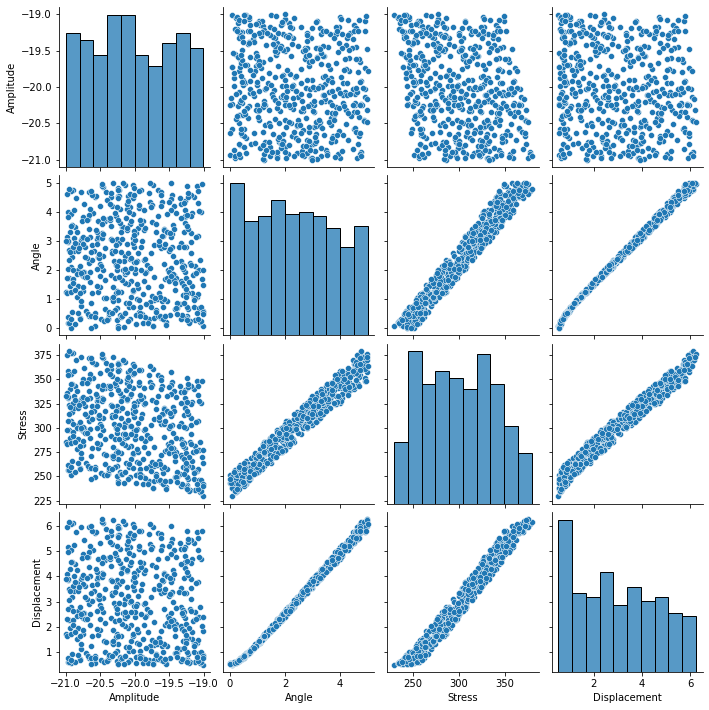

In [19]:
import seaborn as sns
import pandas as pd
in_dict = np.load('/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/MCS/data_determ.npz')
y, f = in_dict['y'], in_dict['f']
df = pd.DataFrame(np.hstack([y,f[:,1:3]]), columns=['Amplitude', 'Angle', 'Stress', 'Displacement'])
sns.pairplot(df)

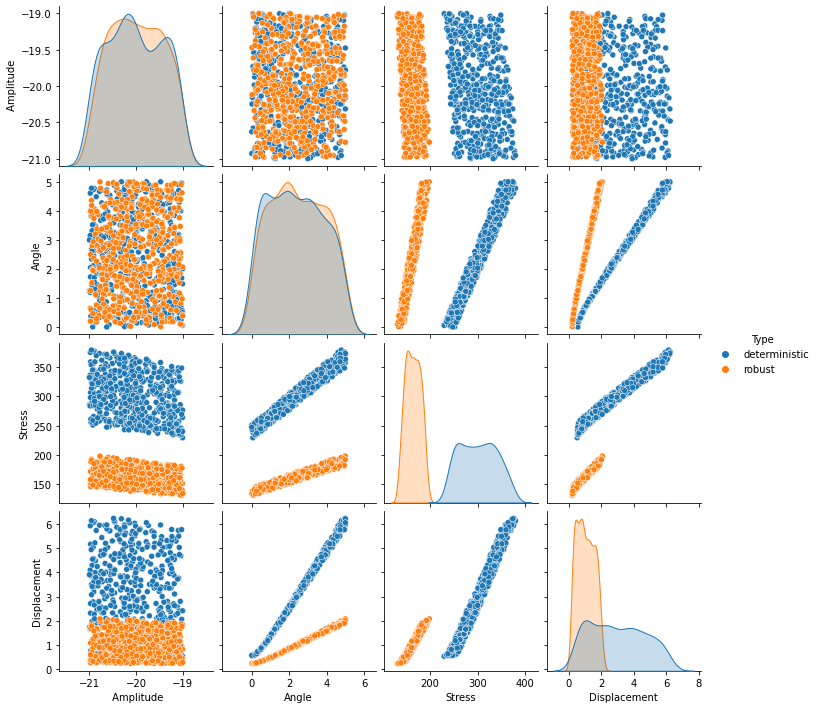

In [23]:
in_dict = np.load('/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/MCS/data_determ.npz')
yd, fd = in_dict['y'], in_dict['f']
in_dict = np.load('/vegas/teaching/Stochastics_Optimization/Optimization_SummerTerm/2021_SS/RDO_Shape_Optimization/results/MCS/data.npz')
yr, fr = in_dict['y'], in_dict['f']
descriptord = np.empty((len(yd),1))
descriptord[:] = 0
descriptorr = np.empty((len(yd),1))
descriptorr[:] = 1

data = np.vstack([np.hstack([descriptord,yd,fd[:,1:3]]),
           np.hstack([descriptorr, yr,fr[:,1:3]])])
                     
df = pd.DataFrame(data, columns=['Type',' Amplitude', 'Angle', 'Stress', 'Displacement'])
df['Type'][df['Type']==0]='deterministic'
df['Type'][df['Type']==1]='robust'
sns.pairplot(df, hue="Type")